#### This notebook performs the same computation as ./src, and serves as an alternative for people who prefers notebooks over command lines.

In [1]:
from unet2d.model.unet_model import UNet2D
from unet2d.model.losses import PixelwiseBCEWithLogitsLoss
from unet2d.model.metrics import DiceCoefficientWithLogits
from unet2d.train import train_model
from unet2d.data import AugTransformConstantPosWeights, Dataset, normalize
from unet2d.utils import smooth

import numpy as np
import numpy.random as random
import h5py

import imgaug as ia
import imgaug.parameters as iap
import imgaug.augmenters as iaa
import imgaug.augmentables.kps as kps

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.optim as optim

from matplotlib import pyplot as plt
import yaml
import csv
import sys
import os

2025-01-30 22:34:56.620928: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 22:34:56.635358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738276496.651155 3660651 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738276496.656029 3660651 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 22:34:56.674076: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### User-specified parameters

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:3" if use_cuda else "cpu") ### specify which GPU on this server you'd like to use for training & inference

path_config = "/store1/candy/prj_unet2d/unet2d-head-detector-train.yaml"
path_h5 = "/store1/candy/prj_unet2d/data/preCropNet_cropped.h5"
path_root = "/store1/candy/prj_unet2d/exp"

with open(path_config, 'r') as stream:
    try:
        config_data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

exp_name = config_data["exp_name"]
path_exp_base = os.path.join(path_root, exp_name)
path_log_tb = os.path.join(path_exp_base, "runs", exp_name)
path_checkpoint = os.path.join(path_exp_base, exp_name + ".tar")
path_log_csv = os.path.join(path_exp_base, exp_name + ".csv")
path_png_output = os.path.join(path_exp_base, exp_name + "predictions")
if not os.path.isdir(path_exp_base):
    os.mkdir(path_exp_base)

args = {
    "start_epoch": config_data["start_epoch"],
    "print_freq": config_data["print_freq"],
    "checkpoint_freq": config_data["checkpoint_freq"],
    "n_epochs": config_data["n_epochs"],
    "n_features": config_data["n_features"],
    "lr_scheduler_patience": config_data["lr_scheduler_patience"],
    "lr_scheduler_factor": config_data["lr_scheduler_factor"],
    "loss_weight": config_data["loss_weight"],
    "learning_rate": config_data["lr"],
    "batch_size": config_data["batch_size"],
    "scaling_factor": config_data["scaling_factor"],
    "n_test": config_data["n_test"],
    "n_val": config_data["n_val"],
    "augmentation": config_data["augmentation"],
    "path_checkpoint": path_checkpoint,
    "path_log_tb": path_log_tb,
    "path_log_csv": path_log_csv
    }

### Train-val-test split by animal by index ranges such that whole animals were withheld from training

In [4]:
with h5py.File(path_h5, "r") as h5f:
    dataset_names = list(h5f.keys())
    
list_img = []
list_label = []
with h5py.File(path_h5, "r") as h5f:
    for datasetname_ in dataset_names:
        dataset_ = h5f[datasetname_]
        list_img.append(
            np.moveaxis(np.expand_dims(dataset_["img"][()]/args["scaling_factor"],axis=2), [0,1,2], [2,1,0]))
        list_label.append(
            np.moveaxis(np.expand_dims(dataset_["label"][()],axis=2), [0,1,2], [2,1,0]).astype(bool))


### images and labels were rolled in consecutively by animal in generate_data_from_data_dict.ipynb and generate_data_from_image_click.ipynb
idx_test = np.arange(0, args["n_test"]) ### reserve the first 500 images as test data
idx_val = np.arange(args["n_test"], args["n_test"]+args["n_val"]) ### reserve the next 500 images as validation data
idx_train = np.arange(args["n_test"]+args["n_val"], len(list_img)) ### the rest goes to training

X_test = np.concatenate(list(map(list_img.__getitem__, idx_test)), axis=0)
Y_test = np.concatenate(list(map(list_label.__getitem__, idx_test)), axis=0)

X_val = np.concatenate(list(map(list_img.__getitem__, idx_val)), axis=0)
Y_val = np.concatenate(list(map(list_label.__getitem__, idx_val)), axis=0)

X_train = np.concatenate(list(map(list_img.__getitem__, idx_train)), axis=0)
Y_train = np.concatenate(list(map(list_label.__getitem__, idx_train)), axis=0)

### Visualize train, val, test images & labels

Text(0.5, 0.98, 'Train set i=0')

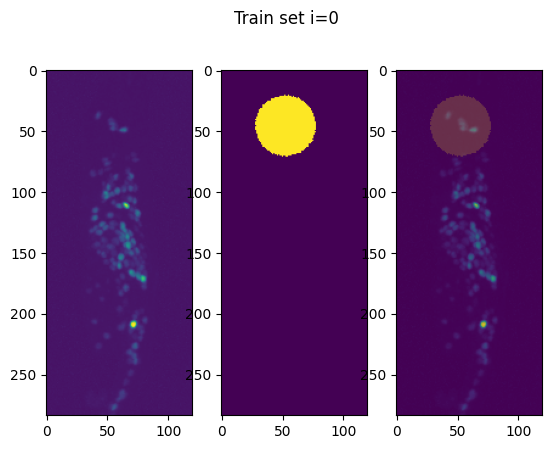

In [10]:
idx_train = 0
plt.subplot(1,3,1)
plt.imshow(X_train[idx_train,:,:], vmin=0, vmax=1)
plt.subplot(1,3,2)
plt.imshow(Y_train[idx_train,:,:])
plt.subplot(1,3,3)
plt.imshow(X_train[idx_train,:,:])
plt.imshow(Y_train[idx_train,:,:], alpha=0.2)
plt.suptitle(f"Train set i={idx_train}")

Text(0.5, 0.98, 'Val set i=0')

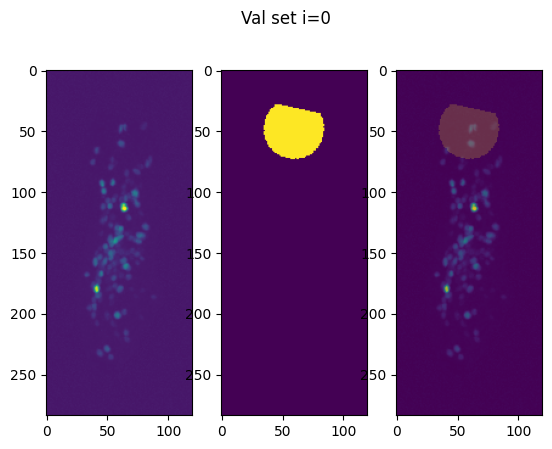

In [12]:
idx_val = 0
plt.subplot(1,3,1)
plt.imshow(X_val[idx_val,:,:], vmin=0, vmax=1)
plt.subplot(1,3,2)
plt.imshow(Y_val[idx_val,:,:])
plt.subplot(1,3,3)
plt.imshow(X_val[idx_val,:,:])
plt.imshow(Y_val[idx_val,:,:], alpha=0.2)
plt.suptitle(f"Val set i={idx_val}")

Text(0.5, 0.98, 'Val set i=0')

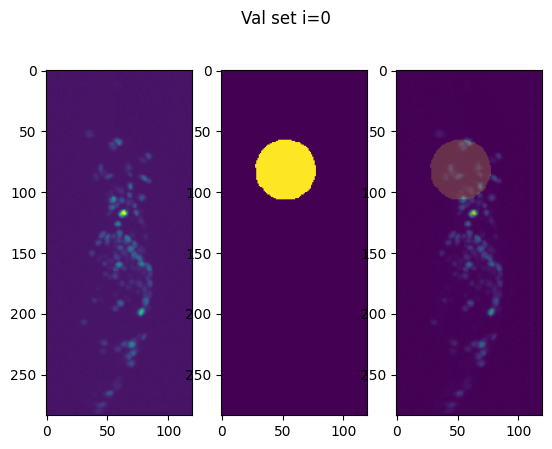

In [13]:
idx_test = 0
plt.subplot(1,3,1)
plt.imshow(X_test[idx_test,:,:], vmin=0, vmax=1)
plt.subplot(1,3,2)
plt.imshow(Y_test[idx_test,:,:])
plt.subplot(1,3,3)
plt.imshow(X_test[idx_test,:,:])
plt.imshow(Y_test[idx_test,:,:], alpha=0.2)
plt.suptitle(f"Val set i={idx_test}")

### Set augmentation parameters for training set

In [15]:
augmentation_params = args["augmentation"]
aug_train = iaa.Sequential([
    iaa.TranslateX(px=tuple(augmentation_params["TranslateX"]["px"])),
    iaa.TranslateY(px=tuple(augmentation_params["TranslateY"]["px"])),
    iaa.Fliplr(augmentation_params["Fliplr"]),
    iaa.Flipud(augmentation_params["Flipud"]),
    iaa.GaussianBlur(sigma=tuple(augmentation_params["GaussianBlur"]["sigma"])),
    iaa.LinearContrast(tuple(augmentation_params["LinearContrast"])),
    iaa.Multiply(tuple(augmentation_params["Multiply"])),
    iaa.Sometimes(
        augmentation_params["Sometimes"],
        iaa.ElasticTransformation(
            alpha=tuple(augmentation_params["ElasticTransformation"]["alpha"]),
            sigma=augmentation_params["ElasticTransformation"]["sigma"]
        )
    ),
    iaa.Affine(
        scale=iap.Normal(
            augmentation_params["Affine"]["scale_mean"],
            augmentation_params["Affine"]["scale_std"]
        ),
        rotate=tuple(augmentation_params["Affine"]["rotate"]),
        shear=iap.Normal(
            augmentation_params["Affine"]["shear_mean"],
            augmentation_params["Affine"]["shear_std"]
        )
    )
])

### Load train, val, test set

In [18]:
tfm_train = AugTransformConstantPosWeights(aug_train, args["loss_weight"])
data_train = Dataset(X_train, Y_train, tfm_train)
data_train_loader = utils.data.DataLoader(data_train,
                                     shuffle=True, num_workers=0, batch_size=args["batch_size"])

tfm_val = AugTransformConstantPosWeights(iaa.Identity(), args["loss_weight"])
data_val = Dataset(X_val, Y_val, tfm_val)
data_val_loader = utils.data.DataLoader(data_val,
                                     shuffle=False, num_workers=0, batch_size=args["batch_size"])

train_val_loader = {"train": data_train_loader, "val": data_val_loader}


tfm_test = AugTransformConstantPosWeights(iaa.Identity(), args["loss_weight"])
data_test = Dataset(X_test, Y_test, tfm_test)
test_loader = utils.data.DataLoader(data_test,
                                     shuffle=False, num_workers=0, batch_size=args["batch_size"])

### Define model

In [20]:
model = UNet2D(1,1,args["n_features"],False)
model.to(device)

model_optimizer = optim.Adam(model.parameters(), lr=config_data["lr"])
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,
                                                    patience=args["lr_scheduler_patience"],
                                                    factor=args["lr_scheduler_factor"])
f_loss = PixelwiseBCEWithLogitsLoss()
f_metric = DiceCoefficientWithLogits()

print("Trainable model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable model parameters: 31042369


### Train & validate model --> save the best checkpoint

In [ ]:
if os.path.isfile(path_checkpoint): # checkpoint restart
    print("continuing training from a checkpoint")
    dict_checkpoint = torch.load(path_checkpoint)
    args["start_epoch"] = dict_checkpoint["epoch"] + 1
    model.load_state_dict(dict_checkpoint["model_state_dict"])
    model_optimizer.load_state_dict(dict_checkpoint["optimizer_state_dict"])
    lr_scheduler.load_state_dict(dict_checkpoint["scheduler_state_dict"])

best_weights = train_model(model, device, train_val_loader, 
                           f_loss, f_metric,
                           model_optimizer, lr_scheduler, 
                           args, True, False)

savepath_best = os.path.join(path_exp_base, exp_name + "_best.pt")
torch.save(best_weights, savepath_best)

savepath_final = os.path.join(path_exp_base, exp_name + "_final.pt")
torch.save(model.state_dict(), savepath_final)

print(f"Best weights saved here: {savepath_best}")

### Test best checkpoint on withheld test data --> output as png

In [21]:
from tqdm import tqdm

def load_model(model_path, n_features, device):
    """Load the trained UNet model."""
    model = UNet2D(1, 1, n_features, False)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def save_prediction(image, truth, pred, save_path, index, dice_score=None):
    """Save the prediction visualization."""
    plt.figure(figsize=(10, 5))
    
    # Original image
    plt.subplot(131)
    plt.imshow(image[0].squeeze(), cmap='gray')  # Remove channel dimension
    plt.title('Original Image')
    plt.axis('off')
    
    # Ground truth
    plt.subplot(132)
    plt.imshow(truth[0].squeeze(), cmap='jet')  # Remove channel dimension
    title = 'Ground truth'
    if dice_score is not None:
        title += f' (Dice: {dice_score:.3f})'
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    
    # Prediction
    plt.subplot(133)
    if dice_score is not None:
        plt.imshow(pred[0].squeeze(), cmap='jet')  # Remove channel dimension
        plt.title('Prediction')
        plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    os.makedirs(save_path, exist_ok=True)
    
    # New filename format
    if dice_score is not None:
        filename = f'dice{dice_score:.3f}_sample{index:04d}.png'
    else:
        filename = f'sample{index:04d}.png'
    
    plt.savefig(os.path.join(save_path, filename), bbox_inches='tight', dpi=150)
    plt.close()

def compute_dice_score(pred, target):
    """
    Compute Dice score between binary masks.
    pred and target should be binary tensors.
    """
    smooth = 1e-5
    intersection = (pred & target).float().sum()
    union = pred.float().sum() + target.float().sum()
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def run_inference(model, test_loader, device, output_dir, metric_fn):
    """Run inference and evaluate results."""
    dice_scores = []
    
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    with torch.no_grad():
        for idx, sample in enumerate(tqdm(test_loader, desc="Processing")):
            # Get data
            x = sample["x"]
            y_true = sample["y_true"]
            
            # Move to device
            x = x.to(device, non_blocking=True)
            y_true = y_true.to(device, non_blocking=True)
            
            # Forward pass
            y_pred = model(x) # logits
            y_pred = torch.sigmoid(y_pred) # prob 0-1
            
            # Get binary prediction
            pred_mask = (y_pred > 0.5)
            
            # Calculate binary dice score
            dice_score = compute_dice_score(pred_mask, y_true.bool())
            dice_scores.append(dice_score.item())
            
            # Save visualization
            save_prediction(
                x.cpu().numpy(),               # Shape: [1, 1, H, W]
                y_true.cpu().numpy(),          # Shape: [1, 1, H, W]
                y_pred.cpu().numpy(),          # Shape: [1, 1, H, W]
                output_dir,
                idx,
                dice_score.item()
            )
    
    # Save dice scores
    scores_file = os.path.join(output_dir, 'dice_scores.csv')
    with open(scores_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Image', 'Dice Score'])
        for idx, score in enumerate(dice_scores):
            writer.writerow([f'Image_{idx:04d}', f'{score:.4f}'])
    
    # Print summary statistics
    print(f"\nDice Scores Summary:")
    print(f"Mean: {np.mean(dice_scores):.4f}")
    print(f"Std: {np.std(dice_scores):.4f}")
    print(f"Min: {np.min(dice_scores):.4f}")
    print(f"Max: {np.max(dice_scores):.4f}")
    print(f"\nDetailed scores saved to: {scores_file}")
    
    return dice_scores

In [ ]:
# Load model
model = load_model(savepath_best, args["n_features"], device)

# Create metric function
metric_fn = DiceCoefficientWithLogits()

# Run inference and evaluation
dice_scores = run_inference(model, test_loader, device, path_png_output, metric_fn)
print(f"Go to {path_png_output} to examine the model outputs for withheld test frames")